**1.Merging**


In [1]:
import pandas as pd

# Read the CSV files

df1 = pd.read_csv('ProductA.csv')
df2 = pd.read_csv('ProductA_fb_impressions.csv')
df3 = pd.read_csv('ProductA_google_clicks.csv')

merged_df = df1.merge(df2,how="left", on='Day Index').merge(df3,how='left', on='Day Index')

cleaned_df = merged_df.dropna()

cleaned_df.to_csv('merged_file.csv', index=False)

print(cleaned_df)

     Day Index  Quantity  Impressions  Clicks
0    12/1/2021        14          620     445
1    12/2/2021        10          890     433
2    12/3/2021        13          851     424
3    12/4/2021        22          881     427
4    12/5/2021        33          678     451
..         ...       ...          ...     ...
207  6/26/2022        13         1218     114
208  6/27/2022        16         1311     106
209  6/28/2022        13          885     109
210  6/29/2022        16         1000      60
211  6/30/2022         8          875      65

[212 rows x 4 columns]


Rows=212
Colums=4

In [2]:
print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Day Index    212 non-null    object
 1   Quantity     212 non-null    int64 
 2   Impressions  212 non-null    int64 
 3   Clicks       212 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.8+ KB
None


 **2. Outliers**

In [3]:
import pandas as pd

df = pd.read_csv('merged_file.csv')

def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))
    return outliers

numeric_columns = df.select_dtypes(include=['number']).columns
outliers_columns = {}

for column in numeric_columns:
    outliers = detect_outliers(df[column])
    if outliers.any():
        outliers_columns[column] = df[column][outliers].tolist()

print(outliers_columns)


{'Quantity': [33, 38, 38, 32, 36]}


Quantity column contains outliers

**Replacing outliers with median**

In [4]:
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)

IQR = Q3 - Q1

quantity_outliers = (df['Quantity'] < (Q1 - 1.5 * IQR)) | (df['Quantity'] > (Q3 + 1.5 * IQR))

quantity_median = df['Quantity'].median()
df['Quantity_new'] = df['Quantity']
df.loc[quantity_outliers, 'Quantity_new'] = quantity_median

print(df.head())


   Day Index  Quantity  Impressions  Clicks  Quantity_new
0  12/1/2021        14          620     445            14
1  12/2/2021        10          890     433            10
2  12/3/2021        13          851     424            13
3  12/4/2021        22          881     427            22
4  12/5/2021        33          678     451            17


**3. Feature engineering**

In [10]:
import pandas as pd

# Load the data from 'Sheet1'
data = pd.read_csv('merged_file.csv')

# # Create date-related features
data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Day'] = data['Day Index'].dt.day
data['Month'] = data['Day Index'].dt.month
data['Year'] = data['Day Index'].dt.year
data['Day of Week'] = data['Day Index'].dt.dayofweek
data['Weekend'] = data['Day Index'].dt.dayofweek >= 5

data['Weekend'] = data['Weekend'].astype(int)

data['December'] = data['Month'].apply(lambda x: 1 if x == 12 else 0)
data['January'] = data['Month'].apply(lambda x: 1 if x == 1 else 0)
data['February'] = data['Month'].apply(lambda x: 1 if x == 2 else 0)
data['March'] = data['Month'].apply(lambda x: 1 if x == 3 else 0)
data['April'] = data['Month'].apply(lambda x: 1 if x == 4 else 0)
data['May'] = data['Month'].apply(lambda x: 1 if x == 6 else 0)
data['June'] = data['Month'].apply(lambda x: 1 if x == 7 else 0)

data['is monday'] = data['Day Index'].dt.dayofweek == 0
data['is monday'] = data['is monday'].astype(int)

data['is tuesday'] = data['Day Index'].dt.dayofweek == 1
data['is tuesday'] = data['is tuesday'].astype(int)

data['is wednesday'] = data['Day Index'].dt.dayofweek == 2
data['is wednesday'] = data['is wednesday'].astype(int)

data['is thursday'] = data['Day Index'].dt.dayofweek == 3
data['is thursday'] = data['is thursday'].astype(int)

data['is friday'] = data['Day Index'].dt.dayofweek == 4
data['is friday'] = data['is friday'].astype(int)

data['is saturday'] = data['Day Index'].dt.dayofweek == 5
data['is saturday'] = data['is saturday'].astype(int)

data['is sunday'] = data['Day Index'].dt.dayofweek == 6
data['is sunday'] = data['is sunday'].astype(int)

# Create rate calculation features

data['Quantity per Impressions'] = data['Quantity']/data['Impressions']
data['Quantity per Clicks'] = data['Quantity']/data['Clicks']

# Add lag features
data['Quantity_lag1'] = data['Quantity'].shift(1)
data['Impressions_lag1'] = data['Impressions'].shift(1)
data['Clicks_lag1'] = data['Clicks'].shift(1)

# Create rolling statistics features (7-day rolling window)
data['Quantity 7-day MA'] = data['Quantity'].rolling(window=7).mean()
data['Impressions 7-day MA'] = data['Impressions'].rolling(window=7).mean()
data['Clicks 7-day MA'] = data['Clicks'].rolling(window=7).mean()

columns_to_replace = [
    'Quantity_lag1',
    'Impressions_lag1',
    'Clicks_lag1',
    'Quantity 7-day MA',
    'Impressions 7-day MA',
    'Clicks 7-day MA'
]

data[columns_to_replace] = data[columns_to_replace].apply(lambda x: x.fillna(x.mean()))

data.to_csv('final.csv', index=False)

print(data.head())

# from IPython.display import display, HTML

# display(HTML(data.to_html(index=False)))

   Day Index  Quantity  Impressions  Clicks  Day  Month  Year  Day of Week  \
0 2021-12-01        14          620     445    1     12  2021            2   
1 2021-12-02        10          890     433    2     12  2021            3   
2 2021-12-03        13          851     424    3     12  2021            4   
3 2021-12-04        22          881     427    4     12  2021            5   
4 2021-12-05        33          678     451    5     12  2021            6   

   Weekend  December  ...  is saturday  is sunday  Quantity per Impressions  \
0        0         1  ...            0          0                  0.022581   
1        0         1  ...            0          0                  0.011236   
2        0         1  ...            0          0                  0.015276   
3        1         1  ...            1          0                  0.024972   
4        1         1  ...            0          1                  0.048673   

   Quantity per Clicks  Quantity_lag1  Impressions_lag1 

**4. Visualization**

**Time series for quantity,clicks,impressions**

      Month  Quantity
0     April       599
1  December       495
2  February       554
3   January       533
4      June       447
5     March       620
6       May       471


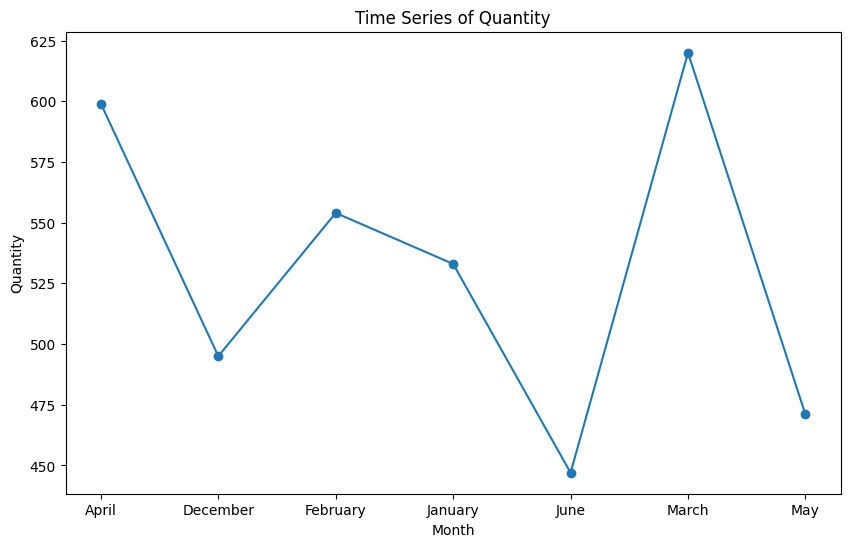

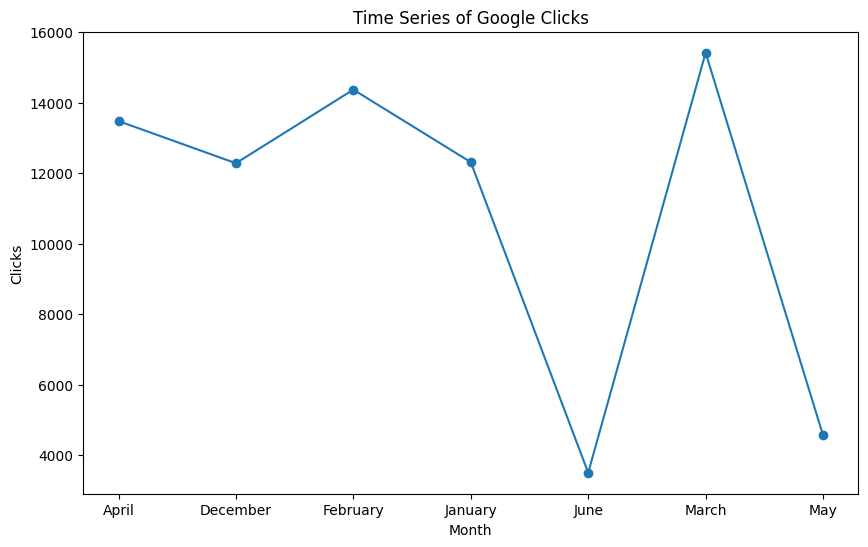

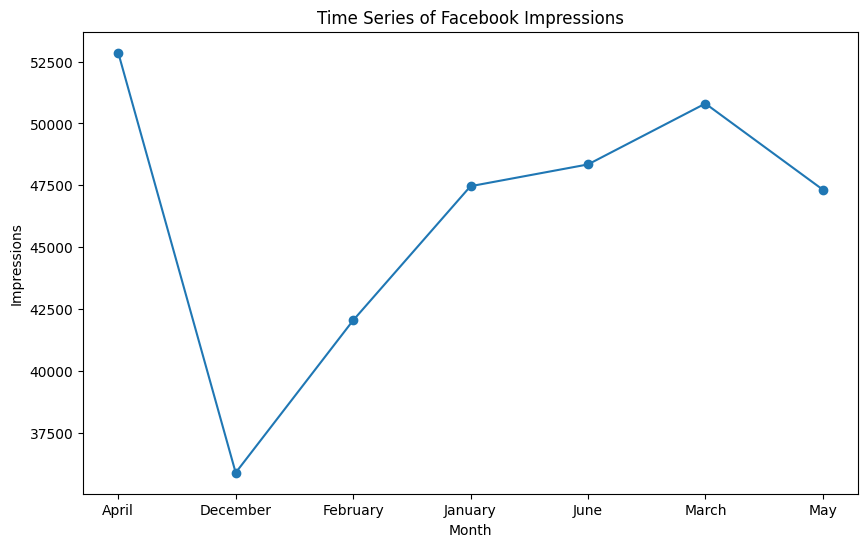

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ProductA.csv')
df['Day Index'] = pd.to_datetime(df['Day Index'])
df['Month'] = df['Day Index'].dt.month_name()
df=df.groupby(['Month'])['Quantity'].sum().reset_index()
print(df)
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Quantity'], marker='o')
plt.title("Time Series of Quantity")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.show()

df = pd.read_csv('ProductA_google_clicks.csv')
df['Day Index'] = pd.to_datetime(df['Day Index'])
df['Month'] = df['Day Index'].dt.month_name()
df=df.groupby(['Month'])['Clicks'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Clicks'], marker='o')
plt.title("Time Series of Google Clicks")
plt.xlabel("Month")
plt.ylabel("Clicks")
plt.show()

df = pd.read_csv('ProductA_fb_impressions.csv')
df['Day Index'] = pd.to_datetime(df['Day Index'])
df['Month'] = df['Day Index'].dt.month_name()
df=df.groupby(['Month'])['Impressions'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Impressions'], marker='o')
plt.title("Time Series of Facebook Impressions")
plt.xlabel("Month")
plt.ylabel("Impressions")
plt.show()

**Google clicks trend line and facebook impressions trend line**

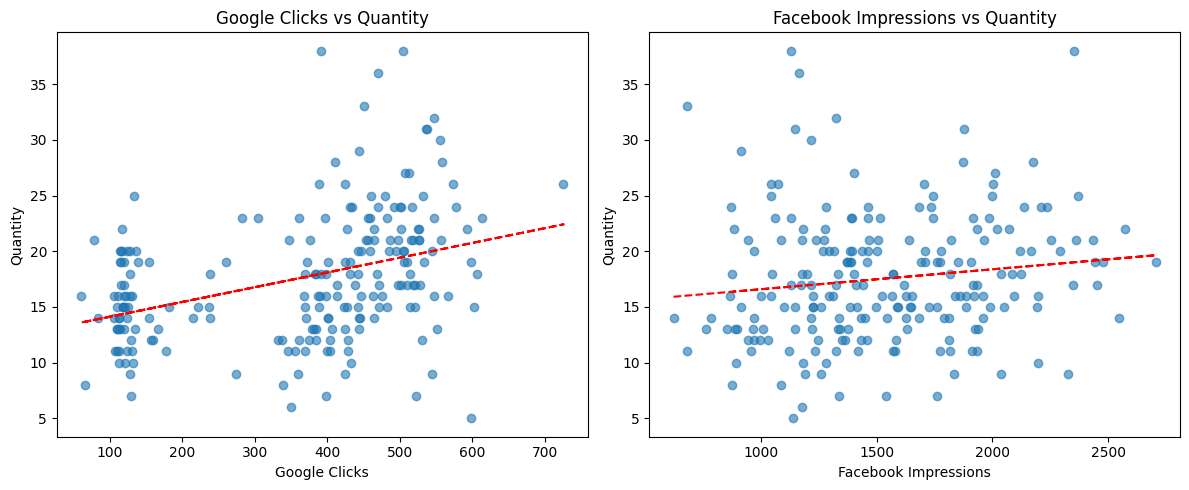

In [ ]:
import numpy as np

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['Clicks'], merged_df['Quantity'], alpha=0.6)
# Add trend line
z = np.polyfit(merged_df['Clicks'], merged_df['Quantity'], 1)
p = np.poly1d(z)
plt.plot(merged_df['Clicks'], p(merged_df['Clicks']), "r--")
plt.title("Google Clicks vs Quantity")
plt.xlabel("Google Clicks")
plt.ylabel("Quantity")

plt.subplot(1, 2, 2)
plt.scatter(merged_df['Impressions'], merged_df['Quantity'], alpha=0.6)
z = np.polyfit(merged_df['Impressions'], merged_df['Quantity'], 1)
p = np.poly1d(z)
plt.plot(merged_df['Impressions'], p(merged_df['Impressions']), "r--")
plt.title("Facebook Impressions vs Quantity")
plt.xlabel("Facebook Impressions")
plt.ylabel("Quantity")

plt.tight_layout()
plt.show()


Here we can see that there is postive correlation between google clicks and quantity and also there is postive correlation between facebook impressions and quantity

**converting the data into days of week**

  Day of Week  Quantity
0      Friday       539
1      Monday       565
2    Saturday       543
3      Sunday       536
4    Thursday       533
5     Tuesday       493
6   Wednesday       510


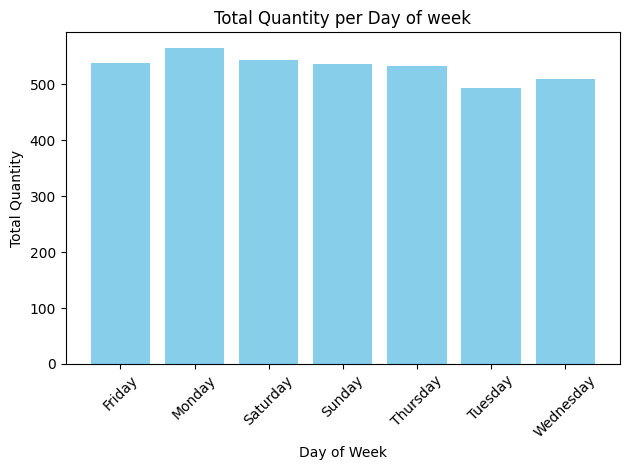

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("ProductA.csv")

data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Day of Week'] = data['Day Index'].dt.day_name()
df=data.groupby(['Day of Week'])['Quantity'].sum().reset_index()
print(df)

plt.bar(df['Day of Week'], df['Quantity'], color='skyblue')
plt.xlabel('Day of Week')
plt.ylabel('Total Quantity')
plt.title('Total Quantity per Day of week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

we can observe that Monday has highest Quantity and Tuesday has lowest Quantity

**converting the data into monthly sales**

      Month  Quantity
0     April       599
1  December       495
2  February       554
3   January       533
4      June       447
5     March       620
6       May       471


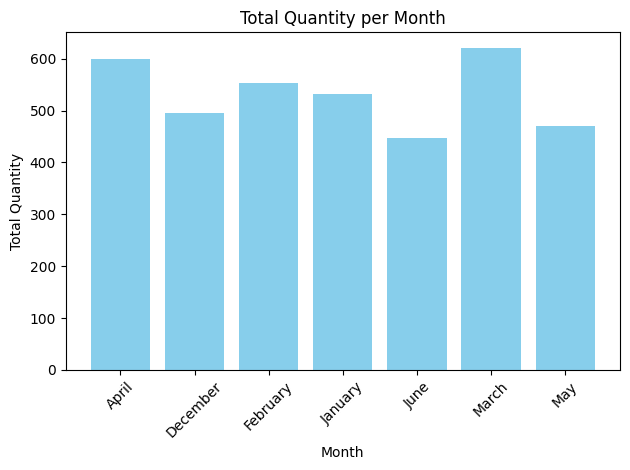

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("ProductA.csv")

data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Month'] = data['Day Index'].dt.month_name()
df=data.groupby(['Month'])['Quantity'].sum().reset_index()
print(df)

plt.bar(df['Month'], df['Quantity'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.title('Total Quantity per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the graph we can say that March has the highest quantity and June has lowest quantity

**Correlation Matrix**

In [11]:
import pandas as pd

df = pd.read_csv('final.csv')

correlation_matrix = df[['Quantity', 'Impressions', 'Clicks','Month','Weekend','December','February', 'January', 'March', 'May', 'June','April','is monday','is tuesday','is wednesday', 'is thursday','is friday']].corr()

print(correlation_matrix)

              Quantity  Impressions    Clicks     Month   Weekend  December  \
Quantity      1.000000     0.135943  0.376041 -0.190532  0.047950 -0.112813   
Impressions   0.135943     1.000000  0.034041 -0.283866  0.069190 -0.352130   
Clicks        0.376041     0.034041  1.000000 -0.239108  0.039863  0.095953   
Month        -0.190532    -0.283866 -0.239108  1.000000 -0.030880  0.884816   
Weekend       0.047950     0.069190  0.039863 -0.030880  1.000000 -0.022926   
December     -0.112813    -0.352130  0.095953  0.884816 -0.022926  1.000000   
February      0.151484    -0.026800  0.368585 -0.316356  0.002334 -0.161440   
January      -0.024996    -0.000571  0.098393 -0.457663  0.036346 -0.171271   
March         0.176060     0.100825  0.350942 -0.213576 -0.022926 -0.171271   
May          -0.185716     0.073633 -0.597133  0.149661 -0.014738 -0.168022   
June               NaN          NaN       NaN       NaN       NaN       NaN   
April         0.170378     0.212592  0.225420 -0.089

**5. Time series analysis**

ADF

In [ ]:
from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('merged_file.csv')

result = adfuller(data['Quantity'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.445717
p-value: 0.000246
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574


Here we can see that p-value is less than 0.05 , we will take this series as stationary.

**ACF and PACF**

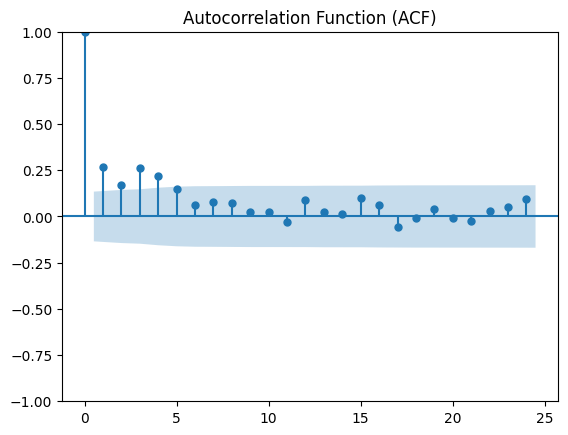

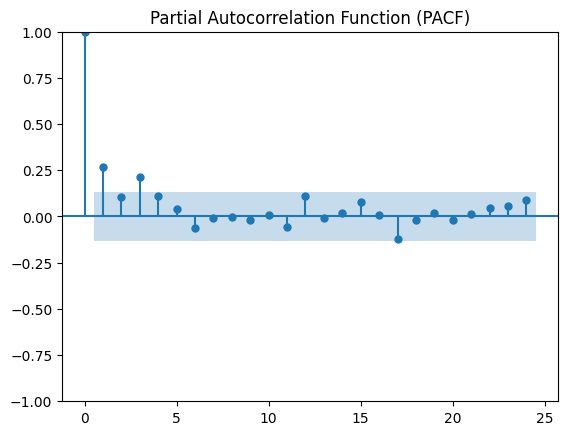

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


data = pd.read_csv('ProductA.csv')


data.index = pd.to_datetime(data['Day Index'])

# Plot ACF
plot_acf(data['Quantity'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(data['Quantity'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In the given ACF plot, significant spikes are observed at lags 1, 2, and 3, followed by a rapid decline. This suggests a possible
q value around 2 or 3.

In the given PACF plot, significant spikes are observed at lags 1, 2, and 3, followed by a rapid decline. This suggests a possible
p value around 2 or 3.

**AR Model**

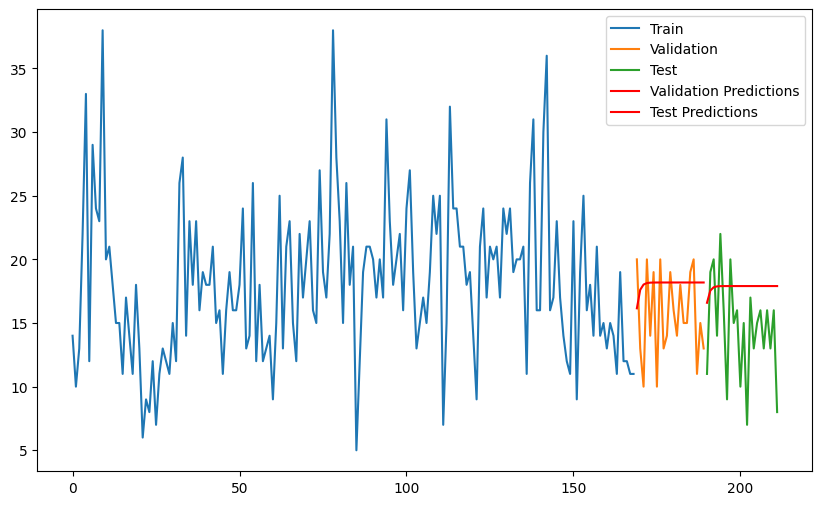

Validation Metrics : 

RMSE: 4.210821822569305
MAPE: 0.27145564260164207
R²: -0.6122433001750134
Adjusted R²: -0.7913814446389038

Test Metrics :

RMSE: 4.997142769378766
Test MAPE: 0.3725821087626428
R²: -0.6991670118172881
Adjusted R²: -0.8780266972717397


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('final.csv')
quantity = data['Quantity']

# Split the data into train, validation, and test sets
train_size = int(len(quantity) * 0.8)
validation_size = int(len(quantity) * 0.1)
train = quantity[:train_size]
validation = quantity[train_size:train_size + validation_size]
test = quantity[train_size + validation_size:]

# Fit the AR model on the training data
model = AutoReg(train, lags=1)
model_fit = model.fit()

# Make predictions on the validation set
validation_predictions = model_fit.predict(start=len(train), end=len(train) + len(validation) - 1, dynamic=False)

# Evaluate the model on the validation set
validation_mse = np.sqrt(mean_squared_error(validation, validation_predictions))
validation_mape = mean_absolute_percentage_error(validation, validation_predictions)
validation_r2 = r2_score(validation, validation_predictions)
n_validation = len(validation)
p_validation = len(model_fit.params)
validation_adjusted_r2 = 1 - (1 - validation_r2) * ((n_validation - 1) / (n_validation - p_validation - 1))

# Update the model with training and validation data
train_validation = pd.concat([train, validation])
model = AutoReg(train_validation, lags=1)
model_fit = model.fit()

# Make predictions on the test set
test_predictions = model_fit.predict(start=len(train_validation), end=len(train_validation) + len(test) - 1, dynamic=False)

# Evaluate the model on the test set
test_mse =np.sqrt( mean_squared_error(test, test_predictions))
test_mape = mean_absolute_percentage_error(test, test_predictions)
test_r2 = r2_score(test, test_predictions)
n_test = len(test)
p_test = len(model_fit.params)
test_adjusted_r2 = 1 - (1 - test_r2) * ((n_test - 1) / (n_test - p_test - 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, validation_predictions, color='red', label='Validation Predictions')
plt.plot(test.index, test_predictions, color='red', label='Test Predictions')
plt.legend()
plt.show()

print("Validation Metrics : ")
print()
print(f'RMSE: {validation_mse}')
print(f'MAPE: {validation_mape}')
print(f'R²: {validation_r2}')
print(f'Adjusted R²: {validation_adjusted_r2}')

print()
print("Test Metrics :")
print()
print(f'RMSE: {test_mse}')
print(f'Test MAPE: {test_mape}')
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adjusted_r2}')

**MA Model**

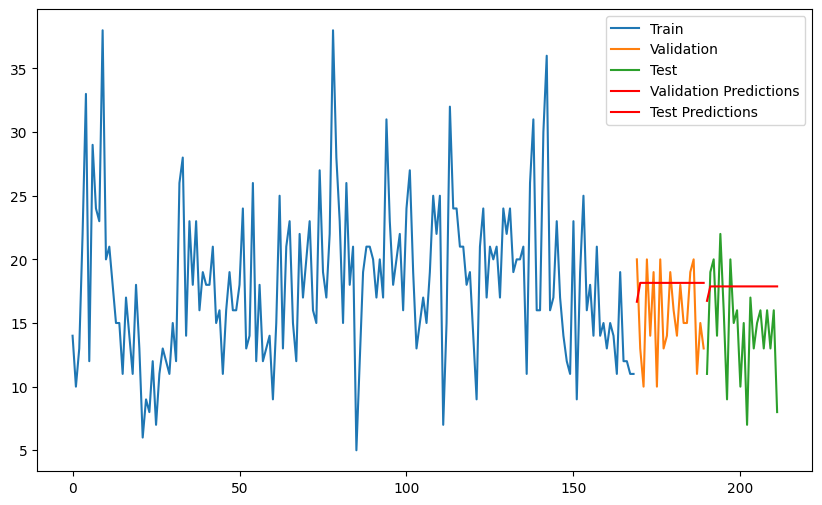

Validation Metrics : 

RMSE: 4.217311568600335
MAPE: 0.2719581993279183
R²: -0.6172167295242774
Adjusted R²: -0.9026079170873853

Test Metrics :

RMSE: 4.983283231997486
MAPE: 0.37078327758095125
R²: -0.6897548287401567
Adjusted R²: -0.9713806335301829


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Load the data
data = pd.read_csv('merged_file.csv')
quantity = data['Quantity']

# Split the data into train, validation, and test sets
train_size = int(len(quantity) * 0.8)
validation_size = int(len(quantity) * 0.1)
train = quantity[:train_size]
validation = quantity[train_size:train_size + validation_size]
test = quantity[train_size + validation_size:]

# Fit the MA model on the training data
model = ARIMA(train, order=(0, 0, 1))
model_fit = model.fit()

# Make predictions on the validation set
validation_predictions = model_fit.predict(start=len(train), end=len(train) + len(validation) - 1, dynamic=False)

# Evaluate the model on the validation set
validation_mse =np.sqrt( mean_squared_error(validation, validation_predictions))
validation_mape = mean_absolute_percentage_error(validation, validation_predictions)
validation_r2 = r2_score(validation, validation_predictions)
n_validation = len(validation)
p_validation = len(model_fit.params)
validation_adjusted_r2 = 1 - (1 - validation_r2) * ((n_validation - 1) / (n_validation - p_validation - 1))

# Update the model with training and validation data
train_validation = pd.concat([train, validation])
model = ARIMA(train_validation, order=(0, 0, 1))
model_fit = model.fit()

# Make predictions on the test set
test_predictions = model_fit.predict(start=len(train_validation), end=len(train_validation) + len(test) - 1, dynamic=False)

# Evaluate the model on the test set
test_mse = np.sqrt(mean_squared_error(test, test_predictions))
test_mape = mean_absolute_percentage_error(test, test_predictions)
test_r2 = r2_score(test, test_predictions)
n_test = len(test)
p_test = len(model_fit.params)
test_adjusted_r2 = 1 - (1 - test_r2) * ((n_test - 1) / (n_test - p_test - 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, validation_predictions, color='red', label='Validation Predictions')
plt.plot(test.index, test_predictions, color='red', label='Test Predictions')
plt.legend()
plt.show()

print("Validation Metrics : ")
print()
print(f'RMSE: {validation_mse}')
print(f'MAPE: {validation_mape}')
print(f'R²: {validation_r2}')
print(f'Adjusted R²: {validation_adjusted_r2}')

print()
print("Test Metrics :")
print()
print(f'RMSE: {test_mse}')
print(f'MAPE: {test_mape}')
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adjusted_r2}')

**ARIMA Model**

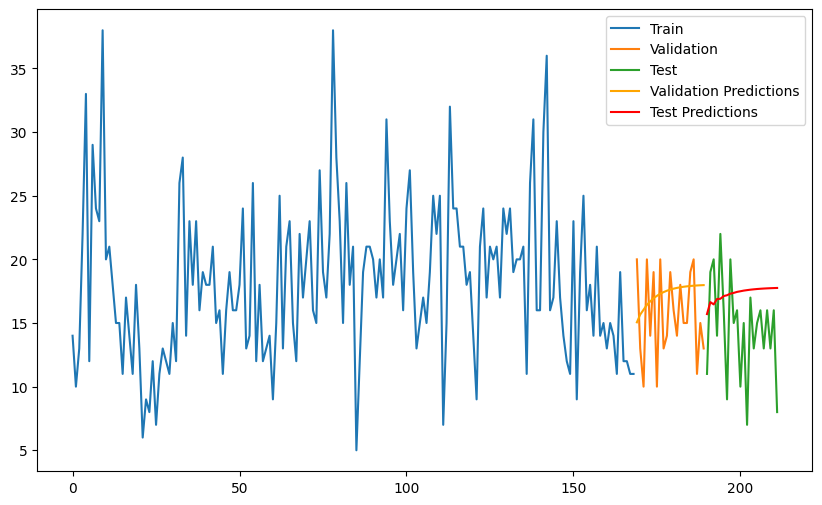

Validation Metrics : 

RMSE: 3.8133423643047712
MAPE: 0.24718012207573453
R²: -0.32223438648331193
Adjusted R²: -0.8889062664047314

Test Metrics :

RMSE: 4.814656686989878
MAPE: 0.3544959077814906
R²: -0.577332321463651
Adjusted R²: -1.2082652500491111


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Load the data
data = pd.read_csv('merged_file.csv')
quantity = data['Quantity']

# Split the data into train, validation, and test sets
train_size = int(len(quantity) * 0.8)
validation_size = int(len(quantity) * 0.1)
train = quantity[:train_size]
validation = quantity[train_size:train_size + validation_size]
test = quantity[train_size + validation_size:]

# Fit the ARIMA model on the training data
model = ARIMA(train, order=(2, 0, 2))
model_fit = model.fit()

# Make predictions on the validation set
validation_predictions = model_fit.predict(start=len(train), end=len(train) + len(validation) - 1, dynamic=False)

# Evaluate the model on the validation set
validation_rmse = np.sqrt(mean_squared_error(validation, validation_predictions))
validation_mape = mean_absolute_percentage_error(validation, validation_predictions)
validation_r2 = r2_score(validation, validation_predictions)
n_validation = len(validation)
p_validation = len(model_fit.params)
validation_adjusted_r2 = 1 - (1 - validation_r2) * ((n_validation - 1) / (n_validation - p_validation - 1))

# Update the model with training and validation data
train_validation = pd.concat([train, validation])
model = ARIMA(train_validation, order=(2, 0, 2))
model_fit = model.fit()

# Make predictions on the test set
test_predictions = model_fit.predict(start=len(train_validation), end=len(train_validation) + len(test) - 1, dynamic=False)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(test, test_predictions))
test_mape = mean_absolute_percentage_error(test, test_predictions)
test_r2 = r2_score(test, test_predictions)
n_test = len(test)
p_test = len(model_fit.params)
test_adjusted_r2 = 1 - (1 - test_r2) * ((n_test - 1) / (n_test - p_test - 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, validation_predictions, color='orange', label='Validation Predictions')
plt.plot(test.index, test_predictions, color='red', label='Test Predictions')
plt.legend()
plt.show()

print("Validation Metrics : ")
print()
print(f'RMSE: {validation_rmse}')
print(f'MAPE: {validation_mape}')
print(f'R²: {validation_r2}')
print(f'Adjusted R²: {validation_adjusted_r2}')

print()
print("Test Metrics :")
print()
print(f'RMSE: {test_rmse}')
print(f'MAPE: {test_mape}')
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adjusted_r2}')

**SARIMA**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


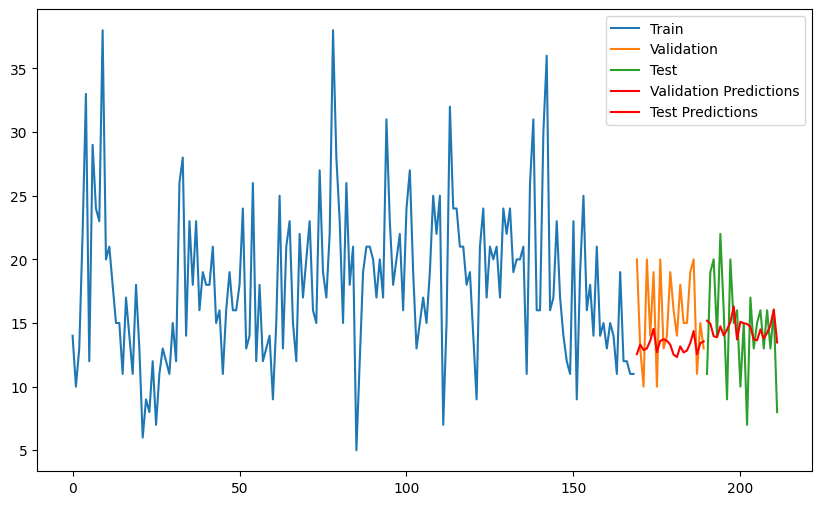

Validation Metrics :
RMSE: 3.9681697972213192
MAPE: 0.19232337213714074
R²: -0.43178347401124806
Adjusted R²: -1.202743806171151

Test Metrics :

RMSE: 3.836413553945038
MAPE: 0.24812427447453328
R²: -0.0014825495763119978
Adjusted R²: -0.3144458463189095


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Load the data
data = pd.read_csv('merged_file.csv')
quantity = data['Quantity']

# Split the data into train, validation, and test sets
train_size = int(len(quantity) * 0.8)
validation_size = int(len(quantity) * 0.1)
train = quantity[:train_size]
validation = quantity[train_size:train_size + validation_size]
test = quantity[train_size + validation_size:]

# Fit the SARIMA model on the training data
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=False)

# Make predictions on the validation set
validation_predictions = model_fit.predict(start=len(train), end=len(train) + len(validation) - 1, dynamic=False)

# Evaluate the model on the validation set
validation_rmse = np.sqrt(mean_squared_error(validation, validation_predictions))
validation_mape = mean_absolute_percentage_error(validation, validation_predictions)
validation_r2 = r2_score(validation, validation_predictions)
n_validation = len(validation)
p_validation = len(model_fit.params)
validation_adjusted_r2 = 1 - (1 - validation_r2) * ((n_validation - 1) / (n_validation - p_validation - 1))


# Update the model with training and validation data
train_validation = pd.concat([train, validation])
model = SARIMAX(train_validation, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=False)

# Make predictions on the test set
test_predictions = model_fit.predict(start=len(train_validation), end=len(train_validation) + len(test) - 1, dynamic=False)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(test, test_predictions))
test_mape = mean_absolute_percentage_error(test, test_predictions)
test_r2 = r2_score(test, test_predictions)
n_test = len(test)
p_test = len(model_fit.params)
test_adjusted_r2 = 1 - (1 - test_r2) * ((n_test - 1) / (n_test - p_test - 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, validation_predictions, color='red', label='Validation Predictions')
plt.plot(test.index, test_predictions, color='red', label='Test Predictions')
plt.legend()
plt.show()


print("Validation Metrics :")
print(f'RMSE: {validation_rmse}')
print(f'MAPE: {validation_mape}')
print(f'R²: {validation_r2}')
print(f'Adjusted R²: {validation_adjusted_r2}')

print()
print("Test Metrics :")
print()
print(f'RMSE: {test_rmse}')
print(f'MAPE: {test_mape}')
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adjusted_r2}')

**ARIMAX**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


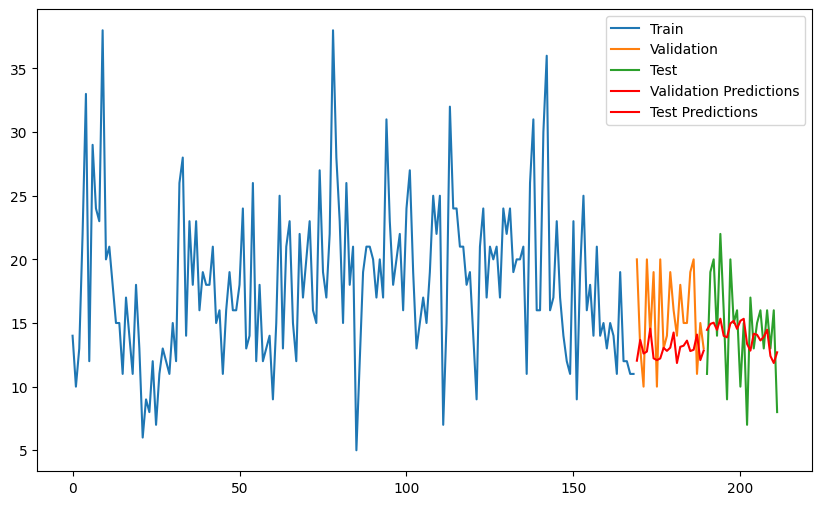

Validation Metrics :
RMSE: 4.442146588855435
MAPE: 0.20861758946958725
R²: -0.7942486279884677
Adjusted R²: -4.980828759961559

Test Metrics :

RMSE: 3.620336872099025
MAPE: 0.2355961217904838
R²: 0.10815266291857173
Adjusted R²: -1.6755420112442847


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Load the data
data = pd.read_csv('final.csv')
quantity = data['Quantity']
exog = data[['Impressions', 'Clicks','Month','Weekend','is monday','is tuesday','is wednesday', 'is thursday','is friday']]  # Replace with your actual exogenous variables

# Split the data into train, validation, and test sets
train_size = int(len(quantity) * 0.8)
validation_size = int(len(quantity) * 0.1)
train, val_test = quantity[:train_size], quantity[train_size:]
train_exog, val_test_exog = exog[:train_size], exog[train_size:]

validation = val_test[:validation_size]
validation_exog = val_test_exog[:validation_size]
test = val_test[validation_size:]
test_exog = val_test_exog[validation_size:]

# Fit the ARIMAX model on the training data
model = SARIMAX(train, exog=train_exog, order=(2, 0, 2))
model_fit = model.fit(disp=False)

# Make predictions on the validation set
validation_predictions = model_fit.predict(start=len(train), end=len(train) + len(validation) - 1, exog=validation_exog, dynamic=False)

# Evaluate the model on the validation set
validation_rmse = np.sqrt(mean_squared_error(validation, validation_predictions))
validation_mape = mean_absolute_percentage_error(validation, validation_predictions)
validation_r2 = r2_score(validation, validation_predictions)
n_validation = len(validation)
p_validation = len(model_fit.params)
validation_adjusted_r2 = 1 - (1 - validation_r2) * ((n_validation - 1) / (n_validation - p_validation - 1))

# Update the model with training and validation data
train_validation = pd.concat([train, validation])
train_validation_exog = pd.concat([train_exog, validation_exog])
model = SARIMAX(train_validation, exog=train_validation_exog, order=(2, 0, 2))
model_fit = model.fit(disp=False)

# Make predictions on the test set
test_predictions = model_fit.predict(start=len(train_validation), end=len(train_validation) + len(test) - 1, exog=test_exog, dynamic=False)

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(test, test_predictions))
test_mape = mean_absolute_percentage_error(test, test_predictions)
test_r2 = r2_score(test, test_predictions)
n_test = len(test)
p_test = len(model_fit.params)
test_adjusted_r2 = 1 - (1 - test_r2) * ((n_test - 1) / (n_test - p_test - 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, validation_predictions, color='red', label='Validation Predictions')
plt.plot(test.index, test_predictions, color='red', label='Test Predictions')
plt.legend()
plt.show()

print("Validation Metrics :")
print(f'RMSE: {validation_rmse}')
print(f'MAPE: {validation_mape}')
print(f'R²: {validation_r2}')
print(f'Adjusted R²: {validation_adjusted_r2}')

print()
print("Test Metrics :")
print()
print(f'RMSE: {test_rmse}')
print(f'MAPE: {test_mape}')
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adjusted_r2}')

**SARIMAX Model**

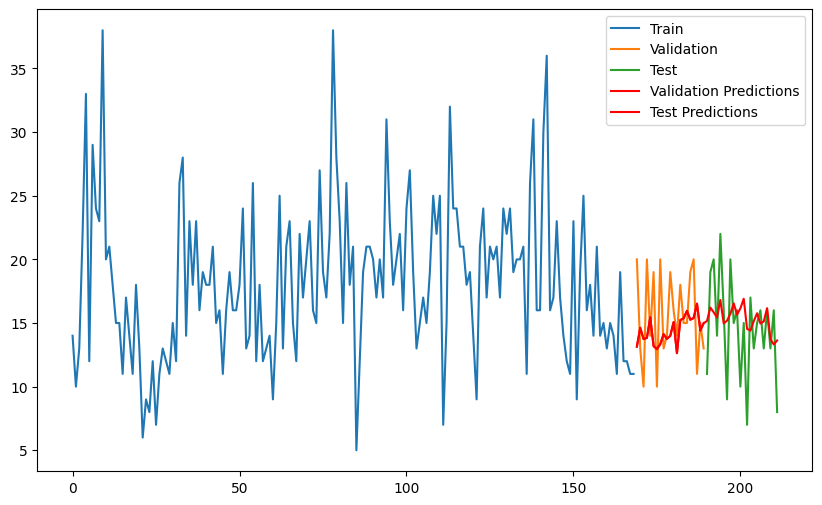

Validation Metrics:

RMSE: 3.7704155071669874
MAPE: 0.19398087889846488
R²: -0.2926331125027244
Adjusted R²: 3.350242022732226

Test Metrics:

RMSE: 3.6890879373413377
MAPE: 0.2229722094518221
R²: -0.034607547802388616
Adjusted R²: 3.172675850385016


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# Load the CSV file
df = pd.read_csv('final.csv')

quantity = data['Quantity']

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
val_size = int(0.10 * len(df))
test_size = len(df) - train_size - val_size

train = data[:train_size]
val = data[train_size:train_size + val_size]
test = data[train_size + val_size:]

tes=data[train_size:]
# Fit the ARIMAX model on the training data

y = df['Quantity']
exog = df[['Impressions', 'Clicks','Month','Weekend','December','February', 'January', 'March', 'May', 'June','April','is monday','is tuesday','is wednesday', 'is thursday','is friday']]

P,D,Q,s=1, 0, 1, 12

# Define and fit the ARIMAX model
model = SARIMAX(train['Quantity'], exog=exog[:train_size], order=(1,0,1), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)


validation_start_index = train_size
validation_end_index = train_size + val_size-1

n_exog = exog.loc[validation_start_index:validation_end_index]

# Generate validation predictions
validation_predictions = model_fit.predict(start=validation_start_index, end=validation_end_index, exog=n_exog)

# Define the start and end index for predictions
start_index = train_size
end_index = len(data)-1

# Create new exogenous variables for prediction period
new_exog = exog.loc[start_index:end_index]

predictions = model_fit.predict(start=start_index, end=end_index, exog=new_exog)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the actual values for the training, validation, and test sets
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(val.index, val['Quantity'], label='Validation')
plt.plot(test.index, test['Quantity'], label='Test')

# Plot the predicted values for the validation and test sets
plt.plot(val.index, validation_predictions, color='red', label='Validation Predictions')
plt.plot(tes.index, predictions, color='red', label='Test Predictions')

# Add legend and show plot
plt.legend()
plt.show()

print("Validation Metrics:")
print()
# Evaluate the model on the validation set
validation_rmse = np.sqrt(mean_squared_error(val['Quantity'], validation_predictions))
validation_mape = mean_absolute_percentage_error(val['Quantity'], validation_predictions)
print(f'RMSE: {validation_rmse}')
print(f'MAPE: {validation_mape}')
# Function to calculate adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Calculate R² for the validation set
val_r2 = r2_score(val['Quantity'], validation_predictions)
val_adj_r2 = adjusted_r2(val_r2, val.shape[0], val.shape[1])
print(f'R²: {val_r2}')
print(f'Adjusted R²: {val_adj_r2}')

print()
print("Test Metrics:")
print()
# Evaluate the model using RMSE and MAPE
rmse = np.sqrt(mean_squared_error(tes['Quantity'], predictions))
mape = mean_absolute_percentage_error(tes['Quantity'], predictions)
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Calculate R² for the test set
test_r2 = r2_score(tes['Quantity'], predictions)
test_adj_r2 = adjusted_r2(test_r2, test.shape[0], test.shape[1])
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adj_r2}')

**Multi Variate Regression Model**

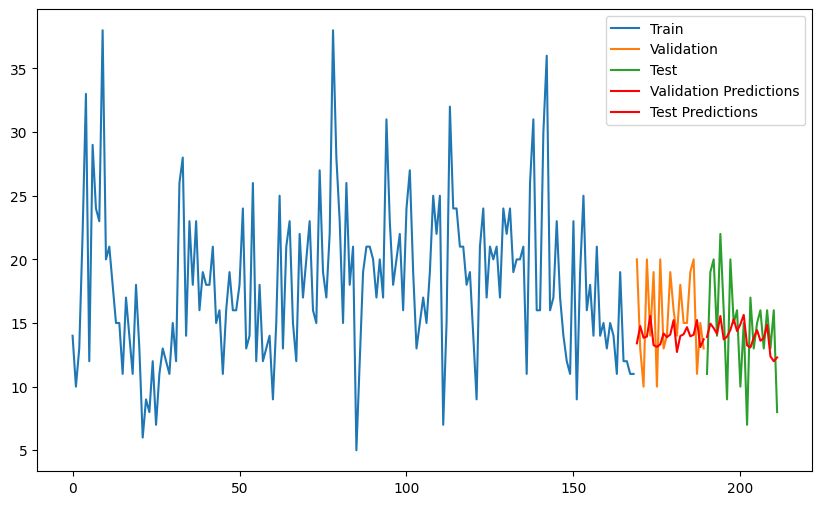

Validation Metrics :

RMSE: 3.8740812643639977
MAPE: 0.19719751130785101
R²: -0.3646909254674644
Adjusted R²: -4.458763701869858

Test Metrics :

RMSE: 3.572490791489023
MAPE: 0.22791062761345504
R²: 0.13157005759137497
Adjusted R²: -2.0395047984301877


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score


# Load the dataset
data = pd.read_csv('final.csv')

features = ['Clicks', 'Impressions', 'is friday', 'is monday','Weekend', 'is thursday', 'is tuesday','is wednesday', 'December',
            'February', 'January', 'March', 'May', 'June','April']

# Calculate the split indices
train_size = int(0.80 * len(data))
val_size = int(0.10 * len(data))
test_size = len(data) - train_size - val_size

train = data.iloc[:train_size]
val = data.iloc[train_size:train_size + val_size]
test = data.iloc[train_size + val_size:]

# Dependent and independent variables
X_train = train[features]
y_train = train['Quantity']


# Train the model
model = LinearRegression()
model.fit(X_train, y_train)


X_val = val[features]
X_test = test[features]

# Make predictions
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Function to calculate adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))


# Make predictions for the training set
train_pred = model.predict(X_train)

# Make predictions for the training set
train_pred = model.predict(X_train)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the actual values for the training, validation, and test sets
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(val.index, val['Quantity'], label='Validation')
plt.plot(test.index, test['Quantity'], label='Test')

# Plot the predicted values for the validation and test sets
plt.plot(val.index, val_pred, color='red', label='Validation Predictions')
plt.plot(test.index, test_pred, color='red', label='Test Predictions')

# Add legend and show plot
plt.legend()
plt.show()

print("Validation Metrics :")
print()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(val['Quantity'], val_pred))
print(f'RMSE: {rmse}')

# Calculate MAPE
mape = mean_absolute_percentage_error(val['Quantity'],val_pred)
print(f'MAPE: {mape}')

# Calculate R² for the validation set
val_r2 = r2_score(val['Quantity'], val_pred)
val_adj_r2 = adjusted_r2(val_r2, X_val.shape[0], X_val.shape[1])
print(f'R²: {val_r2}')
print(f'Adjusted R²: {val_adj_r2}')

print()
print("Test Metrics :")
print()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], test_pred))
print(f'RMSE: {rmse}')

# Calculate MAPE
mape = mean_absolute_percentage_error(test['Quantity'],test_pred)
print(f'MAPE: {mape}')

# Calculate R² for the test set
test_r2 = r2_score(test['Quantity'], test_pred)
test_adj_r2 = adjusted_r2(test_r2, X_test.shape[0], X_test.shape[1])
print(f'R²: {test_r2}')
print(f'Adjusted R²: {test_adj_r2}')

**COMPARISON TABLE**

In [ ]:
import pandas as pd

# Data for the comparison table
data = {
    'Error Metrics / Models': ['RMSE', 'MAPE', 'R²', 'Adjusted R²'],
    'AR (Validation)': [4.21, 0.27, -0.61, -0.79],
    'MA (Validation)': [4.21, 0.27, -0.61, -0.90],
    'ARIMA (Validation)': [3.81, 0.24, -0.32, -0.88],
    'SARIMA (Validation)': [3.96, 0.19, -0.43, -1.20],
    'ARIMAX (Validation)': [4.44, 0.20, -0.79, -4.98],
    'SARIMAX (Validation)': [3.77, 0.19, -0.29, 3.35],
    'Multivariate Regression (Validation)': [3.87, 0.19, -0.36, -4.45],
}

data2={
    'Error Metrics / Models': ['RMSE', 'MAPE', 'R²', 'Adjusted R²'],
    'AR (Test)': [4.99, 0.37, -0.69, -0.87],
    'MA (Test)': [4.98, 0.37, -0.68, -0.97],
    'ARIMA (Test)': [4.81, 0.35, -0.57, -1.20],
    'SARIMA (Test)': [3.83, 0.24, -0.0014, -0.31],
    'ARIMAX (Test)': [3.62, 0.23, 0.10, -1.67],
    'SARIMAX (Test)': [3.68, 0.22, -0.03, 3.17],
    'Multivariate Regression (Test)': [3.57, 0.22, 0.13, -2.03]
}

# Create a DataFrame
comparison_df = pd.DataFrame(data)
c2=pd.DataFrame(data2)

# Save the DataFrame to an Excel file
comparison_df.to_excel('model_comparison.xlsx', index=False)
c2.to_excel('model_comparison2.xlsx', index=False)

# Display the DataFrame in a nice tabular format in the output
from IPython.display import display, HTML

display(HTML(comparison_df.to_html(index=False)))
display(HTML(c2.to_html(index=False)))


Error Metrics / Models,AR (Validation),MA (Validation),ARIMA (Validation),SARIMA (Validation),ARIMAX (Validation),SARIMAX (Validation),Multivariate Regression (Validation)
RMSE,4.21,4.21,3.81,3.96,4.44,3.77,3.87
MAPE,0.27,0.27,0.24,0.19,0.20,0.19,0.19
R²,-0.61,-0.61,-0.32,-0.43,-0.79,-0.29,-0.36
Adjusted R²,-0.79,-0.90,-0.88,-1.20,-4.98,3.35,-4.45


Error Metrics / Models,AR (Test),MA (Test),ARIMA (Test),SARIMA (Test),ARIMAX (Test),SARIMAX (Test),Multivariate Regression (Test)
RMSE,4.99,4.98,4.81,3.8300,3.62,3.68,3.57
MAPE,0.37,0.37,0.35,0.2400,0.23,0.22,0.22
R²,-0.69,-0.68,-0.57,-0.0014,0.10,-0.03,0.13
Adjusted R²,-0.87,-0.97,-1.20,-0.3100,-1.67,3.17,-2.03


In [14]:
import pandas as pd

# Data for the comparison table
data = {
    'Error Metrics / Models': ['RMSE', 'MAPE', 'R²', 'Adjusted R²'],
    'AR (Validation)': [4.21, 0.27, -0.61, -0.79],
    'MA (Validation)': [4.21, 0.27, -0.61, -0.90],
    'ARIMA (Validation)': [3.81, 0.24, -0.32, -0.88],
    'SARIMA (Validation)': [3.96, 0.19, -0.43, -1.20],
    'ARIMAX (Validation)': [4.44, 0.20, -0.79, -4.98],
    'SARIMAX (Validation)': [3.77, 0.19, -0.29, 3.35],
    'Multivariate Regression (Validation)': [3.87, 0.19, -0.36, -4.45],
}

data2 = {
    'Error Metrics / Models': ['RMSE', 'MAPE', 'R²', 'Adjusted R²'],
    'AR (Test)': [4.99, 0.37, -0.69, -0.87],
    'MA (Test)': [4.98, 0.37, -0.68, -0.97],
    'ARIMA (Test)': [4.81, 0.35, -0.57, -1.20],
    'SARIMA (Test)': [3.83, 0.24, -0.0014, -0.31],
    'ARIMAX (Test)': [3.62, 0.23, 0.10, -1.67],
    'SARIMAX (Test)': [3.68, 0.22, -0.03, 3.17],
    'Multivariate Regression (Test)': [3.57, 0.22, 0.13, -2.03]
}

# Create DataFrames
comparison_df = pd.DataFrame(data)
c2 = pd.DataFrame(data2)

# Transpose the DataFrames
comparison_df_t = comparison_df.transpose()
c2_t = c2.transpose()

# Save the transposed DataFrames to Excel files
comparison_df_t.to_excel('model_comparison_transposed.xlsx', header=False)
c2_t.to_excel('model_comparison2_transposed.xlsx', header=False)

# Display the transposed DataFrames in a nice tabular format in the output
from IPython.display import display, HTML

display(HTML(comparison_df_t.to_html(header=False)))


Error Metrics / Models,RMSE,MAPE,R²,Adjusted R²
AR (Validation),4.21,0.27,-0.61,-0.79
MA (Validation),4.21,0.27,-0.61,-0.9
ARIMA (Validation),3.81,0.24,-0.32,-0.88
SARIMA (Validation),3.96,0.19,-0.43,-1.2
ARIMAX (Validation),4.44,0.2,-0.79,-4.98
SARIMAX (Validation),3.77,0.19,-0.29,3.35
Multivariate Regression (Validation),3.87,0.19,-0.36,-4.45


In [13]:
display(HTML(c2_t.to_html(header=False)))


Error Metrics / Models,RMSE,MAPE,R²,Adjusted R²
AR (Test),4.99,0.37,-0.69,-0.87
MA (Test),4.98,0.37,-0.68,-0.97
ARIMA (Test),4.81,0.35,-0.57,-1.2
SARIMA (Test),3.83,0.24,-0.0014,-0.31
ARIMAX (Test),3.62,0.23,0.1,-1.67
SARIMAX (Test),3.68,0.22,-0.03,3.17
Multivariate Regression (Test),3.57,0.22,0.13,-2.03


**Conclusion:**

SARIMAX shows the best performance on the validation data, with the lowest RMSE and a positive Adjusted R², indicating it can generalize well during validation.

Multivariate Regression shows the best performance on the test data with the lowest RMSE and the highest R², indicating good predictive accuracy.

Given these insights, SARIMAX is recommended for its strong validation performance, while Multivariate Regression is also noteworthy for its test performance.